In [100]:
from model_trainers.trainer import predict, evaluate
from dataloaders.dataloading import *
from util.search_util import *
from dataloaders.custom_dataloader import *
from models.model_mlp import *
from models.model_small import *
from dataloaders.get_all_samples import *
from dataloaders.imbalanced_dataloader import *

import torch.nn as nn
from torch import optim
import os
import time


In [232]:
# Define the loss function
def loss_fn(output_model, target, Mask):
    lambda_reg = 0.01
    model_loss = nn.CrossEntropyLoss()(output_model, target)
    # Encourage mask values to be close to 1 (after sigmoid)
    # This penalizes deviations from 1
    mask_loss = sum((torch.sigmoid(p) - 1.0).abs().mean() for p in Mask.mask_parameters)
    # print(f"Model loss is {model_loss}, Regularization loss is {mask_loss}")
    return model_loss + lambda_reg * mask_loss # penalize deviations from 1, encourage masks to be close to 1

In [102]:
dataset = 'MNIST'
directory = "/Users/arghasreebanerjee/PycharmProjects/BGD"
batch_size = 100
random_seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 0.001
weight_decay = 0.0001
lr_decay = 0.1
no_model = False
model_directory = directory + f'/models/MLP/model_weights_mnist.pth'
dataset_directory = directory + f'/MNIST'
incorrect_loader_path = f'{directory}/dataloaders/MLP/MNIST_incorrect_loader.pth'

In [193]:

def loader_performance(loaders, model, epoch):  # Always assumes you are passing test and incorrect loader in that order
    names = ['train_loader','test_loader', 'incorrect_loader']
    
    for loader, name in zip(loaders, names):
        y_true = []
        y_hat = []
        for img, label in loader:
            img = img.to(device)
            label = label.to(device)

            output = model(img)
            y_pred = torch.argmax(output, dim=1)
            # print(y_pred)
            # return None
             # Convert tensors to lists for comparison
            y_true.extend(label.cpu().numpy().tolist())
            y_hat.extend(y_pred.cpu().numpy().tolist())
        
        # Convert lists to numpy arrays for comparison
        y_true = np.array(y_true)
        y_hat = np.array(y_hat)
        
        # Calculate accuracy
        acc = np.mean(y_true == y_hat)
        if name == 'incorrect_loader':
            c=np.sum(y_true == y_hat)
            print(f'Number of samples correctly predicted is {c}/{len(loader)}')
        print(f"Accuracy of {name} is {acc} at epoch {epoch}")


In [207]:
def visualize_mask(Mask):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(10, 6))
    for i,p in enumerate(Mask):
        plt.imshow(p.cpu().detach().numpy())
        # plt.show()
        print(f'Parameter {i}')
        print(p)
        print(torch.sigmoid(p))
        print('-'*100)
        break
    print(f"Mask values:")
    for i, p in enumerate(Mask):
        print(f"  Parameter {i}: mean={torch.mean(torch.sigmoid(p)).item():.4f}, std={torch.std(torch.sigmoid(p)).item():.4f}")

    # for i,p in enumerate(Mask):
    #     print(f'Parameter {i}')
    #     print(torch.sum(torch.sigmoid(p)).item())
    #     print(f'Mean of the mask: {torch.mean(torch.sigmoid(p)).item()}')
    #     print('Max of the mask: ', torch.max(torch.sigmoid(p)).item())
    #     print('Min of the mask: ', torch.min(torch.sigmoid(p)).item())
    #     print('-'*100)

In [217]:
def train(loaders, model, Mask, epochs, criterion, optimizer, optimizer_mask):
    sample = loaders[-1]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    # model.train()
    Mask.train()
    acc=0
    loss_=[]

    for epoch in range(epochs):
        # print(f'Epoch {epoch}')
        image, label = sample[0], sample[1]
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        if optimizer_mask is not None:
            optimizer_mask.zero_grad() 
        # y_pred_model = model(image)
        
        y_pred_mask = Mask(image)
        # y_hat_model = torch.argmax(y_pred_model, dim=1) # this is for calculating the accuracy only
        y_hat_mask = torch.argmax(y_pred_mask)
        acc = evaluate(label, y_hat_mask)
        
        # if epoch == 0:
        #     loader_performance(loaders[:-1], Mask, epoch)
        
        if acc!=1.0:
            label_one_hot = torch.nn.functional.one_hot(label, num_classes=10).float()[0].reshape(1, -1)
            loss = criterion(y_pred_mask, label_one_hot, Mask)
            # print(f"Loss is {loss}")
            loss_.append(loss)

            loss.backward()
            optimizer.step()
            if optimizer_mask is not None:
                optimizer_mask.step() # comment this out 
                
            # Debugging why the gradients are so small:
            # print(loss.grad_fn)             
            # print(loss.grad_fn.next_functions)
            # print(Mask.mask_parameters[0].grad.norm().item())
            # visualize_mask(Mask.mask_parameters)
            # loader_performance(loaders[:-1], Mask, epoch) # Accuracy of test data, incorrect loader
        else:
            # If accuracy is already 1.0, the model already correctly predicts the sample
            
            # print(f"Accuracy of sample is {acc} at epoch {epoch}")
            best_model_wts = model.state_dict()
            return best_model_wts, Mask, loss_, True
            # loader_performance(loaders[:-1], Mask, epoch) # Accuracy of test data, incorrect loader
            break
    # if acc==0:
        # print("Could not correctly predict sample")

    best_model_wts = model.state_dict()
    # print("")

    return best_model_wts, Mask, loss_, False

In [106]:
if dataset == 'MED':
    model_directory = directory + f'/models/AlexNet/model_weights_med.pth'
    dataset_directory = directory + f'/MED'
    incorrect_loader_path = f'{directory}/dataloaders/AlexNet/MED_incorrect_loader.pth'

In [107]:
train_loader, valid_loader, test_loader = data_loader_MNIST(directory=directory,
                                                            batch_size=batch_size,
                                                            random_seed=random_seed,
                                                            small=False,
                                                            shuffle=False)
# train_loader, valid_loader, test_loader = data_loader_MED(directory=directory,
#                                                             batch_size=batch_size,
#                                                             random_seed=random_seed,
#                                                             small=False,
#                                                             shuffle=False)

incorrect_loader = torch.load(incorrect_loader_path, map_location=torch.device(device))
        
image, _ = next(iter(train_loader))
model = MLP(num_classes=10, input_size=image.size()[1:])
model = model.to(device)
model.load_state_dict(torch.load(model_directory, map_location=torch.device(device))) # map_loaction for running on local machine

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=lr_decay)


Total batches = 600


<All keys matched successfully>

In [198]:
class Mask(nn.Module):
    def __init__(self, model, random_seed=12):
        super(Mask, self).__init__()
        self.layers = []
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                self.layers.append('Linear')
            elif isinstance(layer, nn.ReLU):
                self.layers.append('ReLU')
            elif isinstance(layer, nn.BatchNorm2d):
                self.layers.append('BatchNorm2d')
            elif isinstance(layer, nn.Dropout):
                self.layers.append('Dropout')
                
        self.model_parameters = list(model.parameters())
        
        # Doing this will completely make the model forget
        torch.manual_seed(random_seed)  # Set the random seed for reproducibility
        self.mask_parameters = nn.ParameterList(nn.Parameter(
            torch.empty(p.size()).uniform_(-1/torch.sqrt(torch.tensor(p.size(0), 
                                                                      dtype=torch.float32)), 
                                           1/torch.sqrt(torch.tensor(p.size(0), dtype=torch.float32))), 
            requires_grad=True) for p in self.model_parameters)
        
        # Testing to see if all the weights are propogated
        # self.mask_parameters = nn.ParameterList(nn.Parameter(torch.ones_like(p), requires_grad=True) for p in self.model_parameters); # comment out sigmoid? 

        # checking if the zero mask is working:
        # self.mask_parameters = nn.ParameterList(nn.Parameter(torch.zeros_like(p), requires_grad=True) for p in self.model_parameters); # comment out sigmoid? 

        
        # for i,_ in enumerate(self.model_parameters):
        #     self.mask_parameters[i] = torch.sigmoid(self.mask_parameters[i])

        
        # self.mask_parameters and self.model_parameters have the same size

    def forward(self, x):
        x = x.reshape(x.size(0), -1) # torch.Size([1, 1, 28, 28]) to torch.Size([1, 784]) @ [784,10] = [1,10]; losing structure?

        for i in range(0, len(self.model_parameters), 2):
            W = self.model_parameters[i]
            b = self.model_parameters[i+1]
            
            masked_W = W * torch.sigmoid(self.mask_parameters[i])
            masked_b = b * torch.sigmoid(self.mask_parameters[i+1])
            # masked_W = W * self.mask_parameters[i]
            # masked_b = b * self.mask_parameters[i+1]

            
            # self.mask_parameters[i] and self.model_parameters[i] match in size
            
            x = nn.functional.linear(x, masked_W, masked_b)
            if i!=len(self.model_parameters)-2:
                if self.layers[i+1] == 'ReLU':
                    x = nn.functional.relu(x)
                if self.layers[i+1] == 'BatchNorm2d':
                    x = nn.functional.batch_norm(x, masked_W, masked_b)
                if self.layers[i+1] == 'Dropout':
                    x = nn.functional.dropout(x, masked_W, masked_b)

      
            # # masked_p = (p * self.mask_parameters[i]) # this change is large, variance is large; LORA - adding would be less; randomly initialized;  bound the change

                
        return x

## 1 mask:

In [ ]:
separate_optimizer = False # have to keep it to False, else the loss decreases too much 

total = len(incorrect_loader)
model.load_state_dict(torch.load(model_directory, map_location=torch.device(device))) # loading the initial model
mask = Mask(model)
c=0
for i,sample in enumerate(incorrect_loader):
    if i ==total:
        break
    print(f'Sample {i}')
    
    # optimizer for the mask:
    if not separate_optimizer:
        optimizer = torch.optim.SGD(list(model.parameters())+list(mask.mask_parameters), lr=.001)
        # optimizer = torch.optim.SGD(list(mask.mask_parameters), lr=learning_rate)
        optimizer_mask = None
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
        optimizer_mask = torch.optim.SGD(mask.mask_parameters, lr=0.0001)
    
    _,_,loss_, correct_prediction = train([train_loader, test_loader, incorrect_loader, sample], 
        model, 
        mask, 
        epochs=100, criterion=loss_fn, optimizer=optimizer,
        optimizer_mask=optimizer_mask)  # Added the optimizer in the same list 
    
    if correct_prediction:
        c+=1
    
        
    # loader_performance([train_loader, test_loader, incorrect_loader], mask, epoch='None')
    # break

print(f'Number of samples correctly predicted is {c}/{total}')

Sample 0
Accuracy of sample is 1.0 at epoch 55
Sample 1
Accuracy of sample is 1.0 at epoch 4
Sample 2
Accuracy of sample is 1.0 at epoch 17
Sample 3
Accuracy of sample is 1.0 at epoch 1
Sample 4
Accuracy of sample is 1.0 at epoch 23
Sample 5
Accuracy of sample is 1.0 at epoch 10
Sample 6
Accuracy of sample is 1.0 at epoch 10
Sample 7
Accuracy of sample is 1.0 at epoch 6
Sample 8
Accuracy of sample is 1.0 at epoch 20
Sample 9
Accuracy of sample is 1.0 at epoch 8
Sample 10
Accuracy of sample is 1.0 at epoch 2
Sample 11
Accuracy of sample is 1.0 at epoch 2
Sample 12
Accuracy of sample is 1.0 at epoch 3
Sample 13
Accuracy of sample is 1.0 at epoch 10
Sample 14
Accuracy of sample is 1.0 at epoch 15
Sample 15
Accuracy of sample is 1.0 at epoch 14
Sample 16
Accuracy of sample is 1.0 at epoch 12
Sample 17
Accuracy of sample is 1.0 at epoch 2
Sample 18
Accuracy of sample is 1.0 at epoch 8
Sample 19
Accuracy of sample is 1.0 at epoch 5
Sample 20
Accuracy of sample is 1.0 at epoch 4
Sample 21
Acc

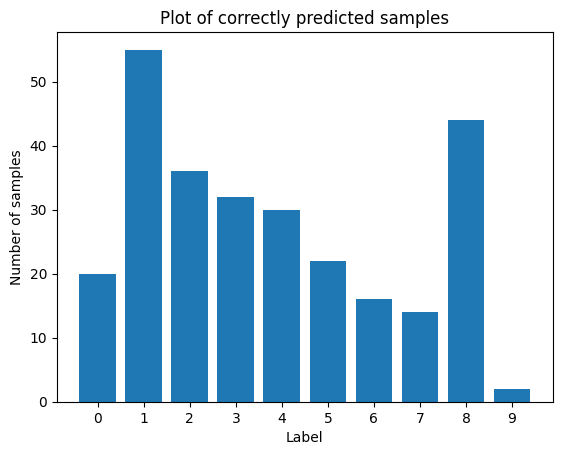

In [184]:
# Analyse the correctly predicted samples
save=[0]*10
for i,sample in enumerate(incorrect_loader):
    if i ==total:
        break
    image, label = sample[0], sample[1]
    y_pred_mask = mask(image)
    y_hat_mask = torch.argmax(y_pred_mask)
    acc = evaluate(label, y_hat_mask)
    if acc==1.0:
        save[label-1]+=1
        
# plot the histogram of the correctly predicted samples
plt.bar(range(10), save)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Plot of correctly predicted samples')
plt.xticks(range(10), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()


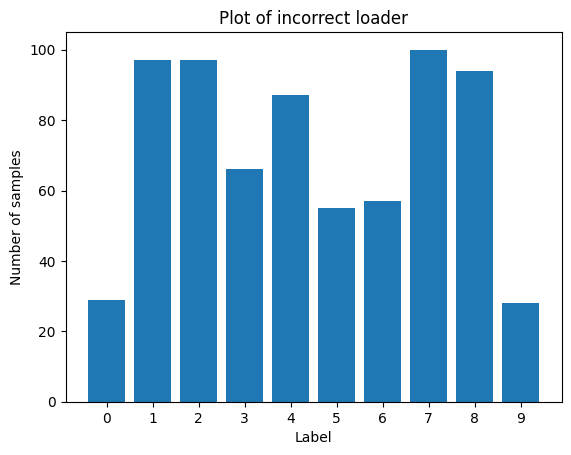

In [183]:
# Analyse the incorrect loader
save=[0]*10
for i,sample in enumerate(incorrect_loader):
    if i ==total:
        break
    image, label = sample[0], sample[1]
    save[label-1]+=1
        
# plot the histogram of the correctly predicted samples
plt.bar(range(10), save)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Plot of incorrect loader')
plt.xticks(range(10), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()


Parameter 0
Parameter containing:
tensor([[-0.0523, -0.0494,  0.0141,  ...,  0.3271,  0.0622, -0.1902],
        [ 0.1646, -0.1834, -0.0816,  ...,  0.2299,  0.3121,  0.3177],
        [-0.1389, -0.1904, -0.1604,  ...,  0.0884,  0.0820,  0.0148],
        ...,
        [-0.0278, -0.0048,  0.2383,  ..., -0.1874, -0.0250, -0.0289],
        [-0.1860, -0.2222,  0.2313,  ..., -0.1698, -0.1906,  0.0942],
        [ 0.0611,  0.0194,  0.1382,  ...,  0.2265, -0.1470,  0.0421]],
       requires_grad=True)
tensor([[0.4869, 0.4877, 0.5035,  ..., 0.5810, 0.5156, 0.4526],
        [0.5410, 0.4543, 0.4796,  ..., 0.5572, 0.5774, 0.5788],
        [0.4653, 0.4526, 0.4600,  ..., 0.5221, 0.5205, 0.5037],
        ...,
        [0.4930, 0.4988, 0.5593,  ..., 0.4533, 0.4937, 0.4928],
        [0.4536, 0.4447, 0.5576,  ..., 0.4577, 0.4525, 0.5235],
        [0.5153, 0.5049, 0.5345,  ..., 0.5564, 0.4633, 0.5105]],
       grad_fn=<SigmoidBackward0>)
------------------------------------------------------------------------

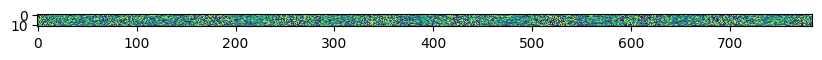

In [157]:
visualize_mask(mask.mask_parameters)

In [158]:
c=0

for i,sample in enumerate(incorrect_loader):
    if i ==total:
        break
    image, label = sample[0], sample[1]
    y_pred_mask = mask(image)
    y_hat_mask = torch.argmax(y_pred_mask)
    acc = evaluate(label, y_hat_mask)
    
    if acc==1.0:
        c+=1
print(f'Number of samples correctly predicted is {c}/{total}')
loader_performance([train_loader, test_loader, incorrect_loader], mask, epoch='None')

Number of samples correctly predicted is 271/710
Accuracy of train_loader is 0.795537037037037 at epoch None
Accuracy of test_loader is 0.8111 at epoch None
Accuracy of incorrect_loader is 0.3816901408450704 at epoch None


Parameter 0
Parameter containing:
tensor([[0.9011, 0.9011, 0.9011,  ..., 0.9011, 0.9011, 0.9011],
        [0.9010, 0.9010, 0.9011,  ..., 0.9010, 0.9011, 0.9010],
        [0.9011, 0.9011, 0.9011,  ..., 0.9011, 0.9011, 0.9011],
        ...,
        [0.9010, 0.9011, 0.9011,  ..., 0.9011, 0.9011, 0.9011],
        [0.9011, 0.9011, 0.9010,  ..., 0.9011, 0.9011, 0.9011],
        [0.9009, 0.9011, 0.9010,  ..., 0.9009, 0.9011, 0.9009]],
       requires_grad=True)
tensor([[0.7112, 0.7112, 0.7112,  ..., 0.7112, 0.7112, 0.7112],
        [0.7112, 0.7112, 0.7112,  ..., 0.7112, 0.7112, 0.7112],
        [0.7112, 0.7112, 0.7112,  ..., 0.7112, 0.7112, 0.7112],
        ...,
        [0.7112, 0.7112, 0.7112,  ..., 0.7112, 0.7112, 0.7112],
        [0.7112, 0.7112, 0.7112,  ..., 0.7112, 0.7112, 0.7112],
        [0.7111, 0.7112, 0.7112,  ..., 0.7111, 0.7112, 0.7111]],
       grad_fn=<SigmoidBackward0>)
----------------------------------------------------------------------------------------------------
Paramet

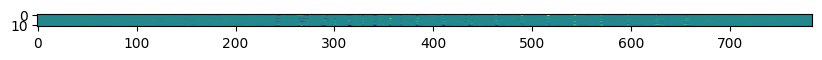

In [98]:
visualize_mask(mask.mask_parameters)

## Multiple Masks:

In [194]:
def bar_plot(incorrect_loader, mask, mask_id):
    save=[0]*10
    for i,sample in enumerate(incorrect_loader):
        if i ==total:
            break
        image, label = sample[0], sample[1]
        y_pred_mask = mask(image)
        y_hat_mask = torch.argmax(y_pred_mask)
        acc = evaluate(label, y_hat_mask)
        if acc==1.0:
            save[label-1]+=1
            
    # plot the histogram of the correctly predicted samples
    plt.bar(range(10), save)
    plt.xlabel('Label')
    plt.ylabel('Number of samples')
    plt.title(f'Plot of correctly predicted samples by mask {mask_id}')
    plt.xticks(range(10), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    plt.show()

In [209]:
def check_if_model_changed(original_model_params, model):
    model_changed = False
    for orig, curr in zip(original_model_params, model.parameters()):
        if not torch.allclose(orig, curr, atol=1e-6):
            model_changed = True
            break
    print(f"Model parameters changed: {model_changed}")

Running corrected version that only optimizes mask parameters...
Mask 0


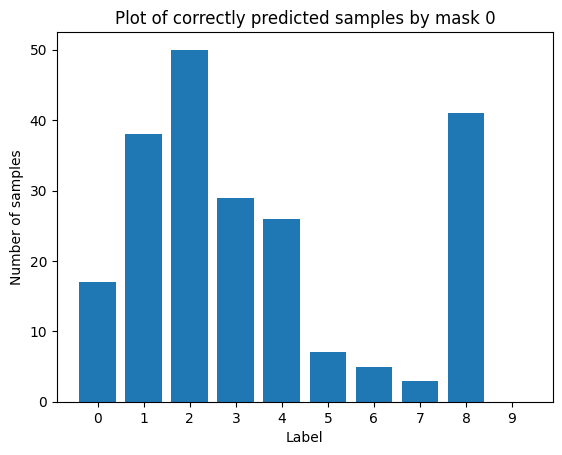

Accuracy of train_loader is 0.8122962962962963 at epoch Mask 0
Accuracy of test_loader is 0.8134 at epoch Mask 0
Number of samples correctly predicted is 216/710
Accuracy of incorrect_loader is 0.30422535211267604 at epoch Mask 0
****************************************************************************************************
Mask 1


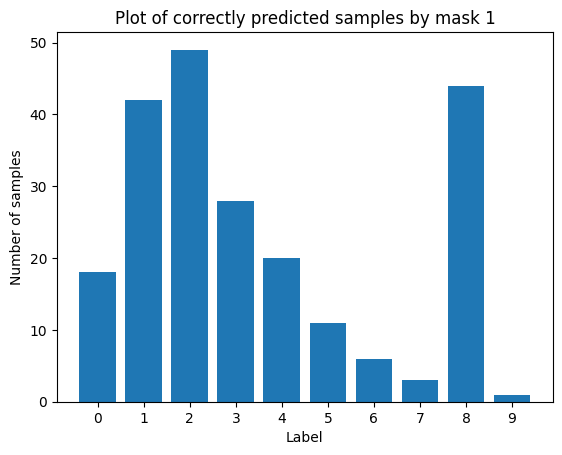

Accuracy of train_loader is 0.8152407407407407 at epoch Mask 1
Accuracy of test_loader is 0.8149 at epoch Mask 1
Number of samples correctly predicted is 222/710
Accuracy of incorrect_loader is 0.3126760563380282 at epoch Mask 1
****************************************************************************************************
Mask 2


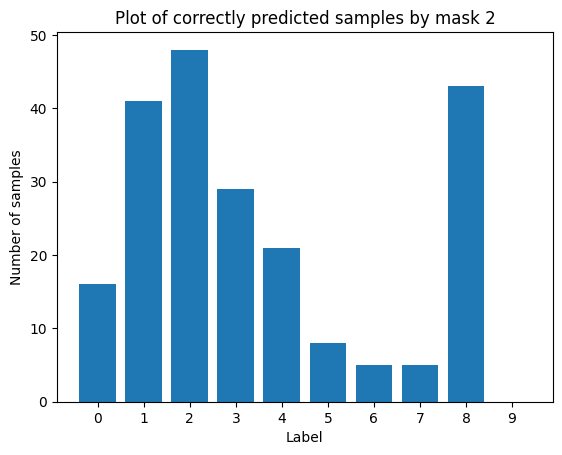

Accuracy of train_loader is 0.8137962962962964 at epoch Mask 2
Accuracy of test_loader is 0.8184 at epoch Mask 2
Number of samples correctly predicted is 216/710
Accuracy of incorrect_loader is 0.30422535211267604 at epoch Mask 2
****************************************************************************************************
Mask 3


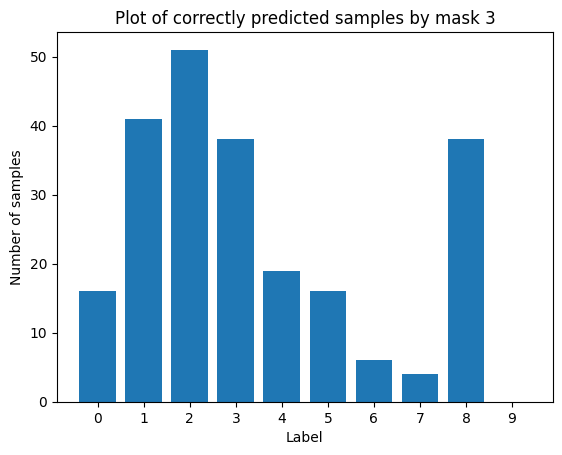

Accuracy of train_loader is 0.8188148148148148 at epoch Mask 3
Accuracy of test_loader is 0.8249 at epoch Mask 3
Number of samples correctly predicted is 229/710
Accuracy of incorrect_loader is 0.32253521126760565 at epoch Mask 3
****************************************************************************************************
Mask 4


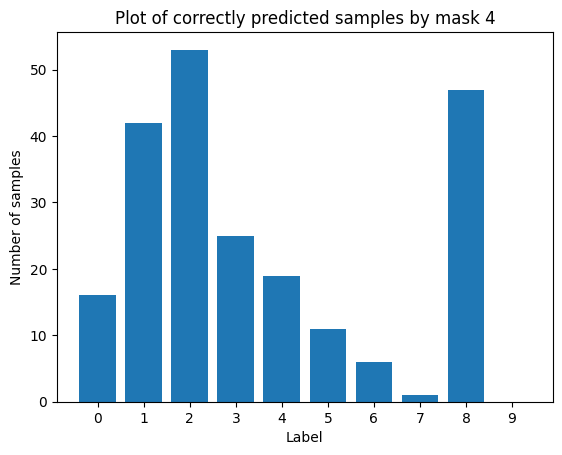

Accuracy of train_loader is 0.812037037037037 at epoch Mask 4
Accuracy of test_loader is 0.8157 at epoch Mask 4
Number of samples correctly predicted is 220/710
Accuracy of incorrect_loader is 0.30985915492957744 at epoch Mask 4
****************************************************************************************************
Mask 5


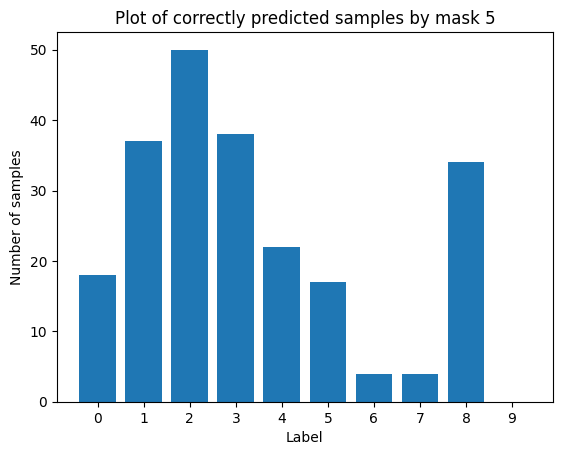

Accuracy of train_loader is 0.8208333333333333 at epoch Mask 5
Accuracy of test_loader is 0.8219 at epoch Mask 5
Number of samples correctly predicted is 224/710
Accuracy of incorrect_loader is 0.3154929577464789 at epoch Mask 5
****************************************************************************************************
Mask 6


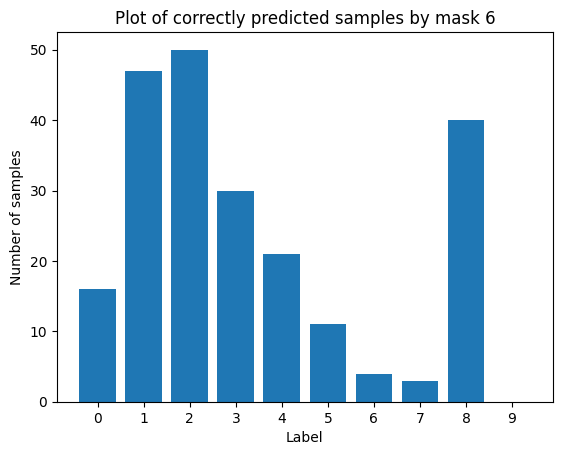

Accuracy of train_loader is 0.8100555555555555 at epoch Mask 6
Accuracy of test_loader is 0.8134 at epoch Mask 6
Number of samples correctly predicted is 222/710
Accuracy of incorrect_loader is 0.3126760563380282 at epoch Mask 6
****************************************************************************************************
Mask 7


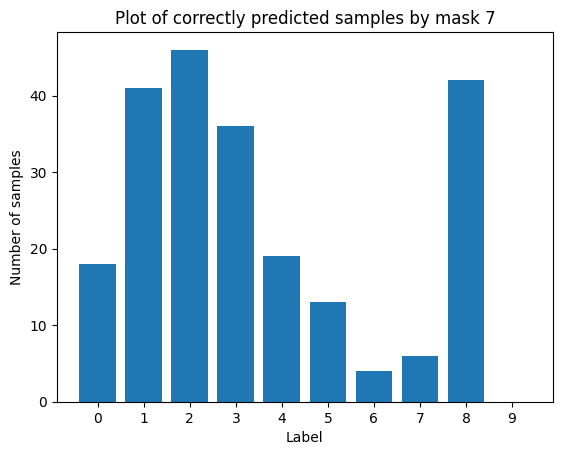

Accuracy of train_loader is 0.8164074074074074 at epoch Mask 7
Accuracy of test_loader is 0.8223 at epoch Mask 7
Number of samples correctly predicted is 225/710
Accuracy of incorrect_loader is 0.31690140845070425 at epoch Mask 7
****************************************************************************************************
Mask 8


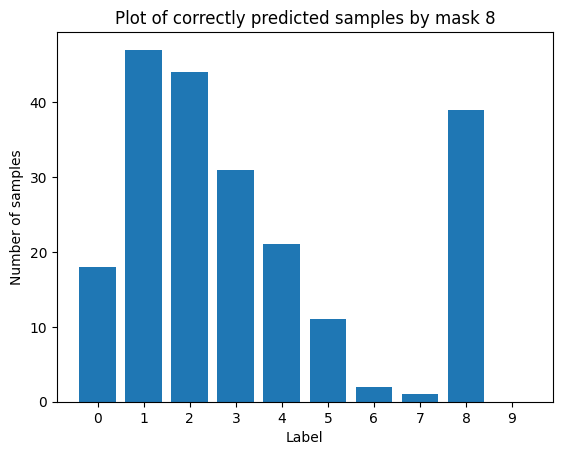

Accuracy of train_loader is 0.8097222222222222 at epoch Mask 8
Accuracy of test_loader is 0.8128 at epoch Mask 8
Number of samples correctly predicted is 214/710
Accuracy of incorrect_loader is 0.30140845070422534 at epoch Mask 8
****************************************************************************************************
Mask 9


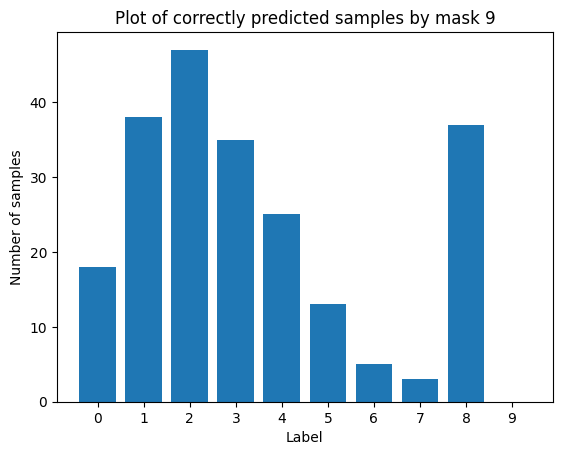

Accuracy of train_loader is 0.8125925925925926 at epoch Mask 9
Accuracy of test_loader is 0.8159 at epoch Mask 9
Number of samples correctly predicted is 221/710
Accuracy of incorrect_loader is 0.3112676056338028 at epoch Mask 9
****************************************************************************************************


In [222]:
# VERSION: Only optimize mask parameters, not model parameters
print("Running corrected version that only optimizes mask parameters...")

total = len(incorrect_loader)

model.load_state_dict(torch.load(model_directory, map_location=torch.device(device)))
# Store original model parameters to verify they don't change
original_model_params = [p.clone().detach() for p in model.parameters()]

for mask_id in range(10):  # Reduced to 3 for testing
    print(f'Mask {mask_id}')
    mask = Mask(model, random_seed=mask_id)
    optimizer = torch.optim.SGD(mask.mask_parameters, lr=.1)
    
    # Test on first few samples only for demonstration
    for i,sample in enumerate(incorrect_loader):
        # print(f'Sample {i}')
        # if i >= 5:  # Only test on first 5 samples for demo
        #     break

        
        _,_,loss_, correct_prediction = train([train_loader, test_loader, incorrect_loader, sample], 
            model, 
            mask, 
            epochs=100, criterion=loss_fn, optimizer=optimizer,
            optimizer_mask=None)
            
    # Verify model parameters haven't changed
    # check_if_model_changed(original_model_params, model)

    # Check mask values to see if they're different
    # visualize_mask(mask.mask_parameters)

    
    bar_plot(incorrect_loader, mask, mask_id)
    loader_performance([train_loader, test_loader, incorrect_loader], mask, epoch=f'Mask {mask_id}')
    print('*'*100)


In [ ]:
# Check if the model changed
loader_performance([train_loader, test_loader, incorrect_loader], model, epoch=f'initial model')
    

Accuracy of train_loader is 0.9332777777777778 at epoch initial model
Accuracy of test_loader is 0.929 at epoch initial model
Number of samples correctly predicted is 0/710
Accuracy of incorrect_loader is 0.0 at epoch initial model


Mask 0


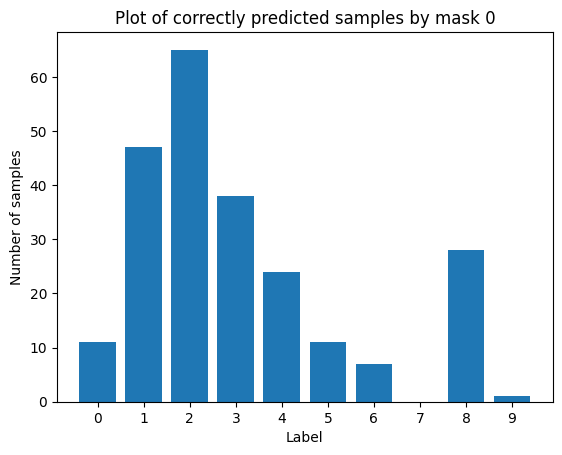

Accuracy of train_loader is 0.7163148148148148 at epoch Mask 0
Accuracy of test_loader is 0.723 at epoch Mask 0
Number of samples correctly predicted is 232/710
Accuracy of incorrect_loader is 0.3267605633802817 at epoch Mask 0
****************************************************************************************************
Mask 1


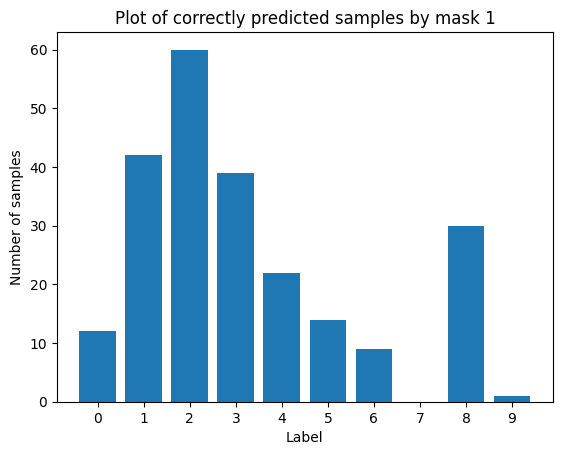

Accuracy of train_loader is 0.7186111111111111 at epoch Mask 1
Accuracy of test_loader is 0.7261 at epoch Mask 1
Number of samples correctly predicted is 229/710
Accuracy of incorrect_loader is 0.32253521126760565 at epoch Mask 1
****************************************************************************************************
Mask 2


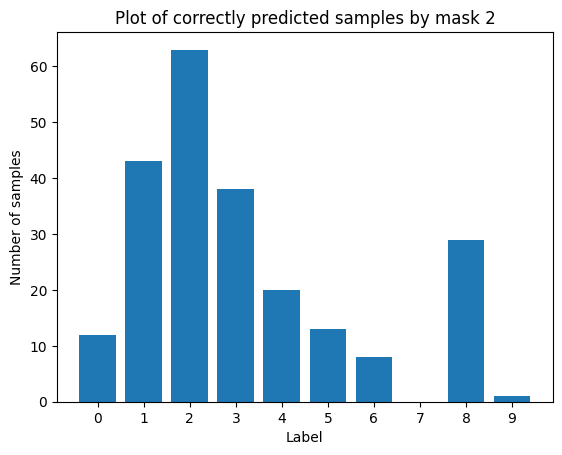

Accuracy of train_loader is 0.7169814814814814 at epoch Mask 2
Accuracy of test_loader is 0.7254 at epoch Mask 2
Number of samples correctly predicted is 227/710
Accuracy of incorrect_loader is 0.31971830985915495 at epoch Mask 2
****************************************************************************************************
Mask 3


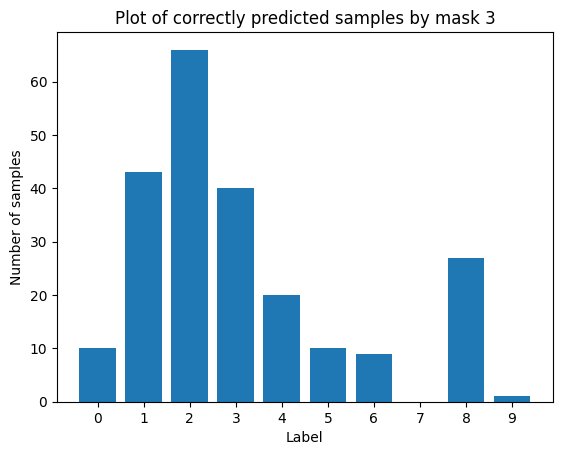

Accuracy of train_loader is 0.7164444444444444 at epoch Mask 3
Accuracy of test_loader is 0.7198 at epoch Mask 3
Number of samples correctly predicted is 226/710
Accuracy of incorrect_loader is 0.3183098591549296 at epoch Mask 3
****************************************************************************************************
Mask 4


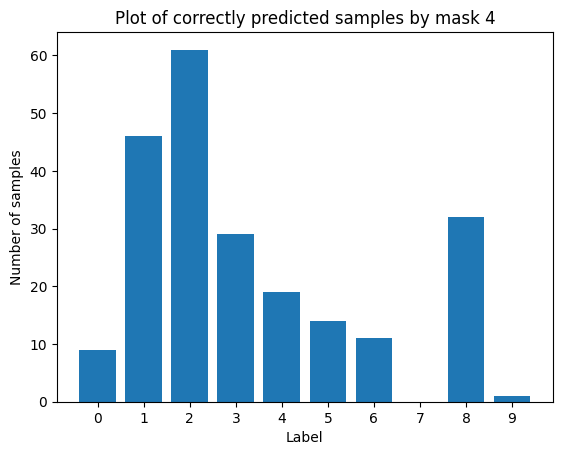

Accuracy of train_loader is 0.7186481481481481 at epoch Mask 4
Accuracy of test_loader is 0.7275 at epoch Mask 4
Number of samples correctly predicted is 222/710
Accuracy of incorrect_loader is 0.3126760563380282 at epoch Mask 4
****************************************************************************************************
Mask 5


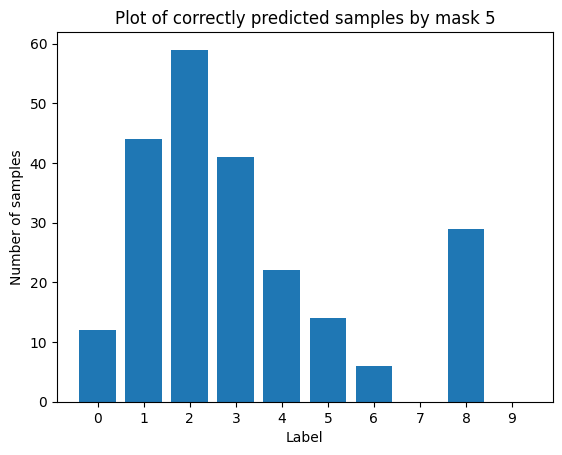

Accuracy of train_loader is 0.7132407407407407 at epoch Mask 5
Accuracy of test_loader is 0.7212 at epoch Mask 5
Number of samples correctly predicted is 227/710
Accuracy of incorrect_loader is 0.31971830985915495 at epoch Mask 5
****************************************************************************************************
Mask 6


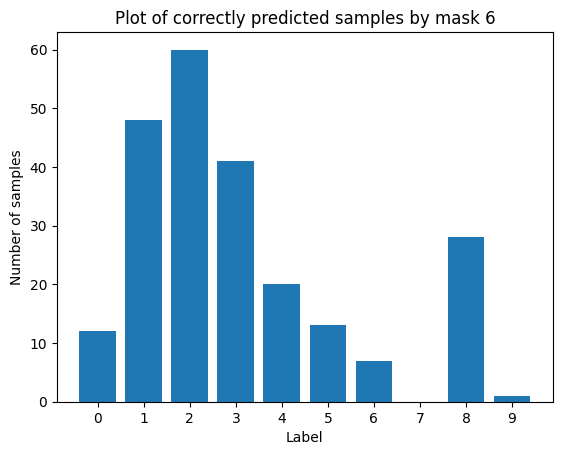

Accuracy of train_loader is 0.7242592592592593 at epoch Mask 6
Accuracy of test_loader is 0.7351 at epoch Mask 6
Number of samples correctly predicted is 230/710
Accuracy of incorrect_loader is 0.323943661971831 at epoch Mask 6
****************************************************************************************************
Mask 7


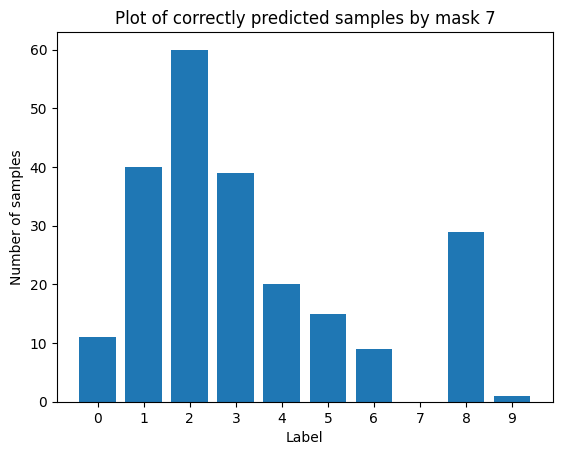

Accuracy of train_loader is 0.7223333333333334 at epoch Mask 7
Accuracy of test_loader is 0.7295 at epoch Mask 7
Number of samples correctly predicted is 224/710
Accuracy of incorrect_loader is 0.3154929577464789 at epoch Mask 7
****************************************************************************************************
Mask 8


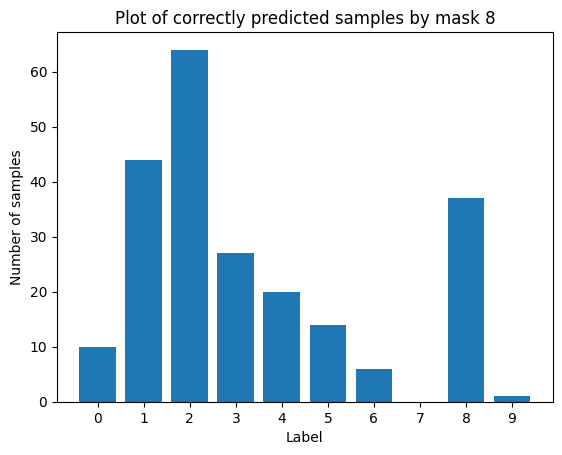

Accuracy of train_loader is 0.7154814814814815 at epoch Mask 8
Accuracy of test_loader is 0.7243 at epoch Mask 8
Number of samples correctly predicted is 223/710
Accuracy of incorrect_loader is 0.31408450704225355 at epoch Mask 8
****************************************************************************************************
Mask 9


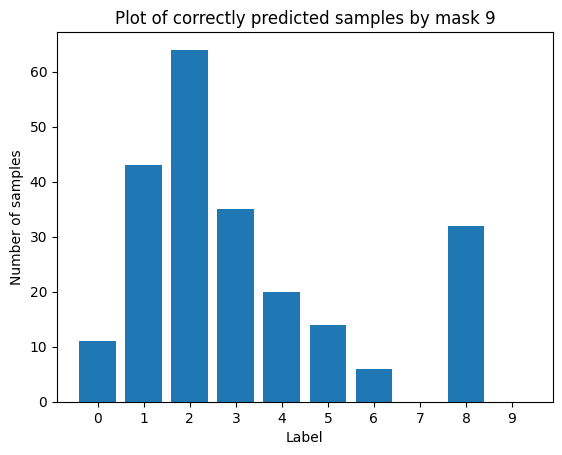

Accuracy of train_loader is 0.7147407407407408 at epoch Mask 9
Accuracy of test_loader is 0.723 at epoch Mask 9
Number of samples correctly predicted is 225/710
Accuracy of incorrect_loader is 0.31690140845070425 at epoch Mask 9
****************************************************************************************************


In [230]:
total = len(incorrect_loader)

original_model_params = [p.clone().detach() for p in model.parameters()]

for mask_id in range(10):  # Reduced to 3 for testing
    print(f'Mask {mask_id}')
    mask = Mask(model, random_seed=mask_id)
    optimizer = torch.optim.SGD(mask.mask_parameters, lr=.1)

    for i,sample in enumerate(incorrect_loader):

        _,_,loss_, correct_prediction = train([train_loader, test_loader, incorrect_loader, sample], 
            model, 
            mask, 
            epochs=100, criterion=loss_fn, optimizer=optimizer,
            optimizer_mask=None)
            
    # Verify model parameters haven't changed
    # check_if_model_changed(original_model_params, model)

    # Check mask values to see if they're different
    # visualize_mask(mask.mask_parameters)

    
    bar_plot(incorrect_loader, mask, mask_id)
    loader_performance([train_loader, test_loader, incorrect_loader], mask, epoch=f'Mask {mask_id}')
    print('*'*100)


### Optimizes model variables as well 

Mask 0
Accuracy of train_loader is 0.9332777777777778 at epoch initial model
Accuracy of test_loader is 0.929 at epoch initial model
Number of samples correctly predicted is 0/710
Accuracy of incorrect_loader is 0.0 at epoch initial model



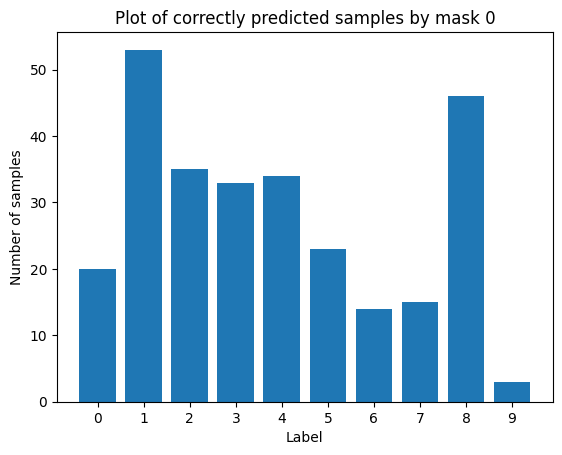

Accuracy of train_loader is 0.8099259259259259 at epoch Mask 0
Accuracy of test_loader is 0.822 at epoch Mask 0
Number of samples correctly predicted is 276/710
Accuracy of incorrect_loader is 0.38873239436619716 at epoch Mask 0
****************************************************************************************************
Mask 1
Accuracy of train_loader is 0.8152037037037037 at epoch initial model
Accuracy of test_loader is 0.8262 at epoch initial model
Number of samples correctly predicted is 272/710
Accuracy of incorrect_loader is 0.38309859154929576 at epoch initial model


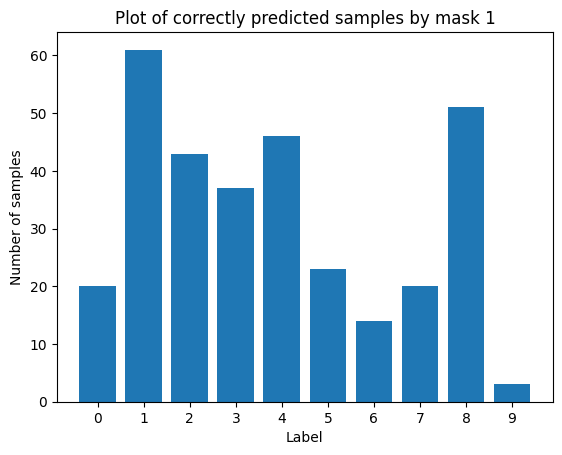

Accuracy of train_loader is 0.7930185185185186 at epoch Mask 1
Accuracy of test_loader is 0.8082 at epoch Mask 1
Number of samples correctly predicted is 318/710
Accuracy of incorrect_loader is 0.447887323943662 at epoch Mask 1
****************************************************************************************************
Mask 2
Accuracy of train_loader is 0.7948518518518518 at epoch initial model
Accuracy of test_loader is 0.8084 at epoch initial model
Number of samples correctly predicted is 308/710
Accuracy of incorrect_loader is 0.43380281690140843 at epoch initial model


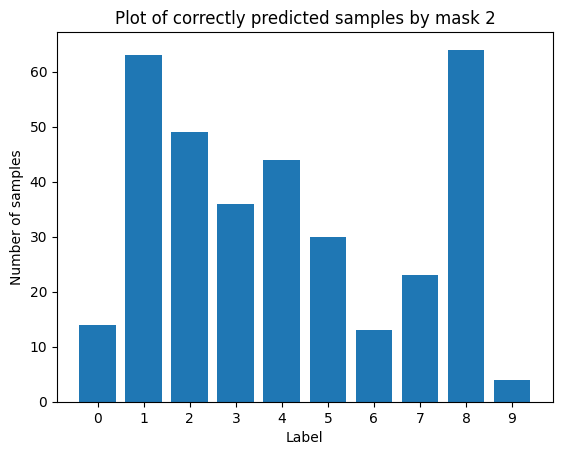

Accuracy of train_loader is 0.7639814814814815 at epoch Mask 2
Accuracy of test_loader is 0.7805 at epoch Mask 2
Number of samples correctly predicted is 340/710
Accuracy of incorrect_loader is 0.4788732394366197 at epoch Mask 2
****************************************************************************************************
Mask 3
Accuracy of train_loader is 0.7648518518518519 at epoch initial model
Accuracy of test_loader is 0.7794 at epoch initial model
Number of samples correctly predicted is 330/710
Accuracy of incorrect_loader is 0.4647887323943662 at epoch initial model


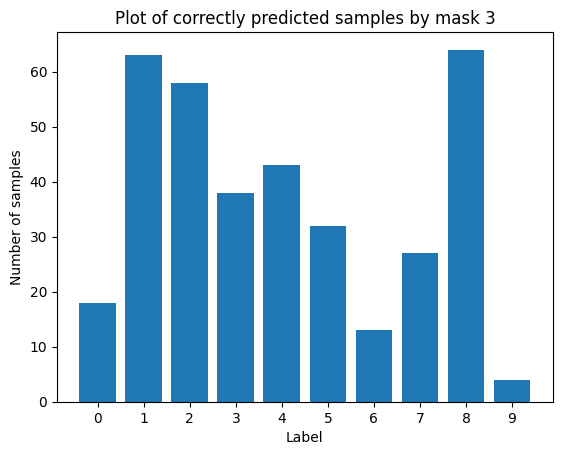

Accuracy of train_loader is 0.7471666666666666 at epoch Mask 3
Accuracy of test_loader is 0.764 at epoch Mask 3
Number of samples correctly predicted is 360/710
Accuracy of incorrect_loader is 0.5070422535211268 at epoch Mask 3
****************************************************************************************************
Mask 4
Accuracy of train_loader is 0.7471481481481481 at epoch initial model
Accuracy of test_loader is 0.7606 at epoch initial model
Number of samples correctly predicted is 354/710
Accuracy of incorrect_loader is 0.49859154929577465 at epoch initial model


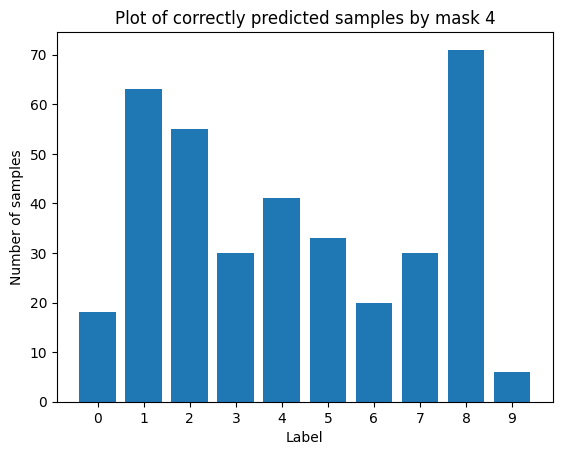

Accuracy of train_loader is 0.7423888888888889 at epoch Mask 4
Accuracy of test_loader is 0.7591 at epoch Mask 4
Number of samples correctly predicted is 367/710
Accuracy of incorrect_loader is 0.5169014084507042 at epoch Mask 4
****************************************************************************************************
Mask 5
Accuracy of train_loader is 0.7431851851851852 at epoch initial model
Accuracy of test_loader is 0.7571 at epoch initial model
Number of samples correctly predicted is 366/710
Accuracy of incorrect_loader is 0.5154929577464789 at epoch initial model


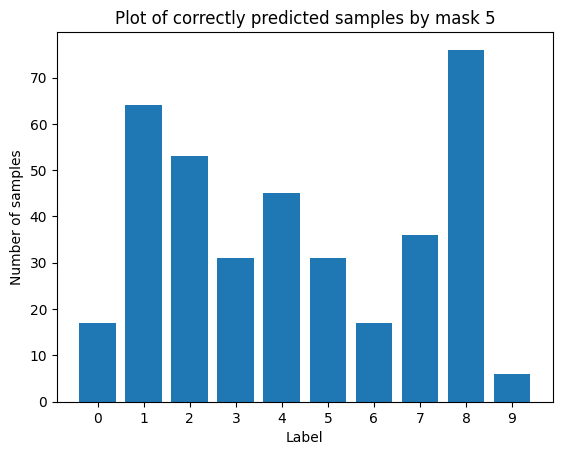

Accuracy of train_loader is 0.7215555555555555 at epoch Mask 5
Accuracy of test_loader is 0.7398 at epoch Mask 5
Number of samples correctly predicted is 376/710
Accuracy of incorrect_loader is 0.5295774647887324 at epoch Mask 5
****************************************************************************************************
Mask 6
Accuracy of train_loader is 0.7206481481481481 at epoch initial model
Accuracy of test_loader is 0.7353 at epoch initial model
Number of samples correctly predicted is 379/710
Accuracy of incorrect_loader is 0.5338028169014084 at epoch initial model


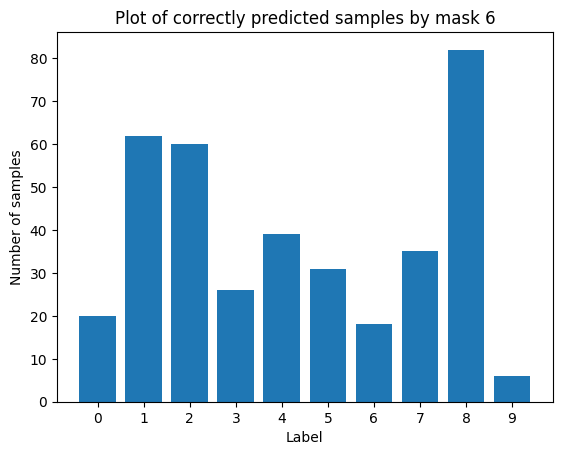

Accuracy of train_loader is 0.7152592592592593 at epoch Mask 6
Accuracy of test_loader is 0.7338 at epoch Mask 6
Number of samples correctly predicted is 379/710
Accuracy of incorrect_loader is 0.5338028169014084 at epoch Mask 6
****************************************************************************************************
Mask 7
Accuracy of train_loader is 0.7046481481481481 at epoch initial model
Accuracy of test_loader is 0.719 at epoch initial model
Number of samples correctly predicted is 371/710
Accuracy of incorrect_loader is 0.5225352112676056 at epoch initial model


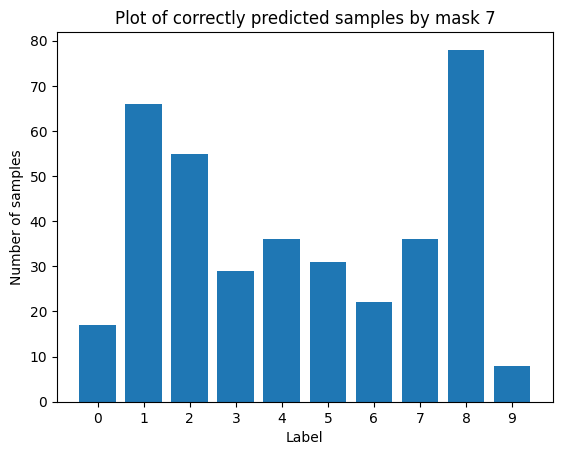

Accuracy of train_loader is 0.7189814814814814 at epoch Mask 7
Accuracy of test_loader is 0.7373 at epoch Mask 7
Number of samples correctly predicted is 378/710
Accuracy of incorrect_loader is 0.532394366197183 at epoch Mask 7
****************************************************************************************************
Mask 8
Accuracy of train_loader is 0.7095 at epoch initial model
Accuracy of test_loader is 0.7238 at epoch initial model
Number of samples correctly predicted is 370/710
Accuracy of incorrect_loader is 0.5211267605633803 at epoch initial model


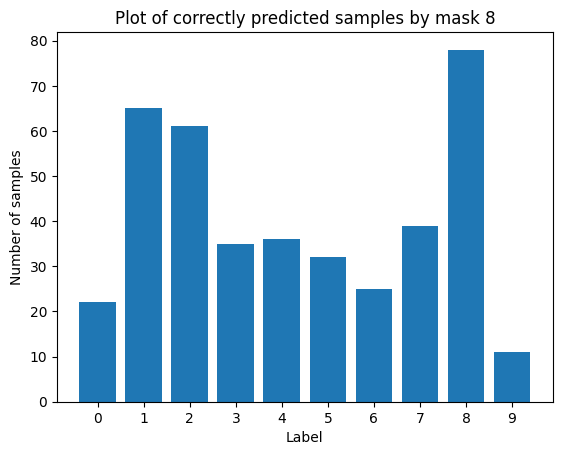

Accuracy of train_loader is 0.7222962962962963 at epoch Mask 8
Accuracy of test_loader is 0.7469 at epoch Mask 8
Number of samples correctly predicted is 404/710
Accuracy of incorrect_loader is 0.5690140845070423 at epoch Mask 8
****************************************************************************************************
Mask 9
Accuracy of train_loader is 0.7106481481481481 at epoch initial model
Accuracy of test_loader is 0.7315 at epoch initial model
Number of samples correctly predicted is 383/710
Accuracy of incorrect_loader is 0.5394366197183098 at epoch initial model


KeyboardInterrupt: 

In [202]:
total = len(incorrect_loader)
model.load_state_dict(torch.load(model_directory, map_location=torch.device(device))) # loading the initial model
for mask_id in range(10):
    print(f'Mask {mask_id}')
    mask = Mask(model, random_seed=mask_id)
    # c=0
    loader_performance([train_loader, test_loader, incorrect_loader], model, epoch=f'initial model')
    
    for i,sample in enumerate(incorrect_loader):
        if i ==total:
            break
        # print(f'Sample {i}')
        
        # optimizer for the mask+model parameters:
        optimizer = torch.optim.SGD(list(model.parameters())+list(mask.mask_parameters), lr=.001)

        
        _,_,loss_, correct_prediction = train([train_loader, test_loader, incorrect_loader, sample], 
            model, 
            mask, 
            epochs=100, criterion=loss_fn, optimizer=optimizer,
            optimizer_mask=None)  # Added the optimizer in the same list 
        
        # if correct_prediction:
        #     c+=1
            
    bar_plot(incorrect_loader, mask, mask_id)
    loader_performance([train_loader, test_loader, incorrect_loader], mask, epoch=f'Mask {mask_id}')
    print('*'*100)
        
            
    # loader_performance([train_loader, test_loader, incorrect_loader], mask, epoch='None')
    # break



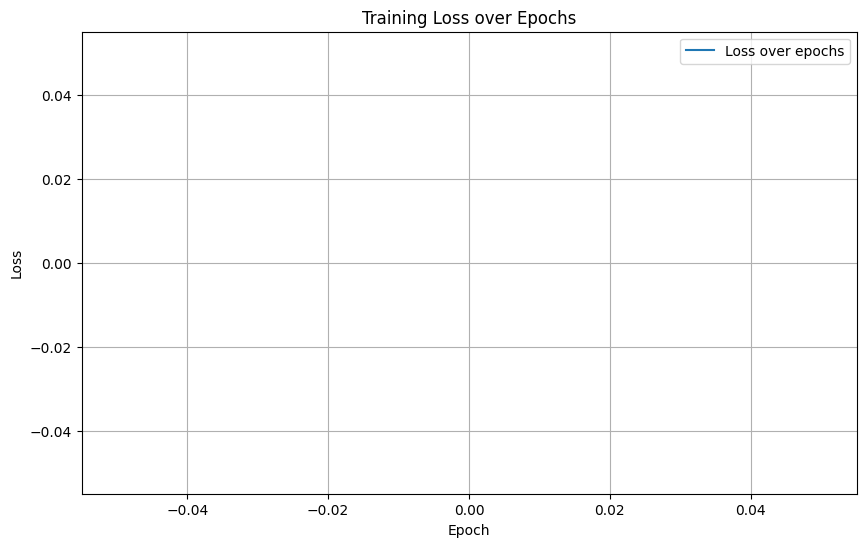

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming loss_ is a list of loss values over epochs
plt.figure(figsize=(10, 6))
plt.plot([i.item() for i in loss_], label='Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## When the model is only trained on cross entropy loss

In [12]:
model.load_state_dict(torch.load(model_directory, map_location=torch.device(device))) # loading the initial model
for i,sample in enumerate(incorrect_loader):
    print(f'Sample {i}')
    # optimizer for the mask:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    loss_over_epoch = []
    total_acc = []
    loss = 0
    for epoch in range(100):
        image, label = sample[0], sample[1]
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        # optimizer_mask.zero_grad()
        y_pred_model = model(image)
        
        y_hat_model = torch.argmax(y_pred_model, dim=1)
        acc = evaluate(label, y_hat_model)
        
        if acc!=1.0:
            loss = criterion(y_pred_model,label)
            # print(f"Loss is {loss}")
            loss_.append(loss.item())
            loss.backward()
            optimizer.step()
        else:
            print(f"Accuracy of sample is {acc} at epoch {epoch}")
            # loader_performance([train_loader, test_loader, incorrect_loader], model, epoch='None')
            break
            

    print("")

    

Sample 0
Accuracy of sample is 1.0 at epoch 5

Sample 1
Accuracy of sample is 1.0 at epoch 0

Sample 2
Accuracy of sample is 1.0 at epoch 2

Sample 3
Accuracy of sample is 1.0 at epoch 0

Sample 4
Accuracy of sample is 1.0 at epoch 2

Sample 5
Accuracy of sample is 1.0 at epoch 2

Sample 6
Accuracy of sample is 1.0 at epoch 2

Sample 7
Accuracy of sample is 1.0 at epoch 0

Sample 8
Accuracy of sample is 1.0 at epoch 3

Sample 9
Accuracy of sample is 1.0 at epoch 1

Sample 10
Accuracy of sample is 1.0 at epoch 1

Sample 11
Accuracy of sample is 1.0 at epoch 0

Sample 12
Accuracy of sample is 1.0 at epoch 1

Sample 13
Accuracy of sample is 1.0 at epoch 1

Sample 14
Accuracy of sample is 1.0 at epoch 2

Sample 15
Accuracy of sample is 1.0 at epoch 1

Sample 16
Accuracy of sample is 1.0 at epoch 2

Sample 17
Accuracy of sample is 1.0 at epoch 1

Sample 18
Accuracy of sample is 1.0 at epoch 1

Sample 19
Accuracy of sample is 1.0 at epoch 1

Sample 20
Accuracy of sample is 1.0 at epoch 1

Sa

In [13]:
c=0

for i,sample in enumerate(incorrect_loader):
    if i ==total:
        break
    image, label = sample[0], sample[1]
    y_pred_mask = mask(image)
    y_hat_mask = torch.argmax(y_pred_mask)
    acc = evaluate(label, y_hat_mask)
    
    if acc==1.0:
        c+=1
print(f'Number of samples correctly predicted is {c}/{total}')
loader_performance([train_loader, test_loader, incorrect_loader], model, epoch='None')

Number of samples correctly predicted is 241/710
Accuracy of train_loader is 0.7230185185185185 at epoch None
Accuracy of test_loader is 0.7328 at epoch None
Accuracy of incorrect_loader is 0.39436619718309857 at epoch None


In [ ]:
# Solution 1: Additive Masking (more expressive than multiplicative)
class AdditiveMask(nn.Module):
    def __init__(self, model, random_seed=12):
        super(AdditiveMask, self).__init__()
        self.layers = []
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                self.layers.append('Linear')
            elif isinstance(layer, nn.ReLU):
                self.layers.append('ReLU')
            elif isinstance(layer, nn.BatchNorm2d):
                self.layers.append('BatchNorm2d')
            elif isinstance(layer, nn.Dropout):
                self.layers.append('Dropout')
                
        self.model_parameters = list(model.parameters())
        
        # Initialize additive masks (can be positive or negative)
        torch.manual_seed(random_seed)
        self.mask_parameters = nn.ParameterList(nn.Parameter(
            torch.zeros_like(p),  # Start with zero masks
            requires_grad=True) for p in self.model_parameters)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)

        for i in range(0, len(self.model_parameters), 2):
            W = self.model_parameters[i]
            b = self.model_parameters[i+1]
            
            # ADDITIVE masking: W + mask (more expressive than W * mask)
            masked_W = W + self.mask_parameters[i]
            masked_b = b + self.mask_parameters[i+1]
            
            x = nn.functional.linear(x, masked_W, masked_b)
            if i!=len(self.model_parameters)-2:
                if self.layers[i+1] == 'ReLU':
                    x = nn.functional.relu(x)
                if self.layers[i+1] == 'BatchNorm2d':
                    x = nn.functional.batch_norm(x, masked_W, masked_b)
                if self.layers[i+1] == 'Dropout':
                    x = nn.functional.dropout(x, masked_W, masked_b)
                
        return x

# Test additive masking
print("Testing additive masking...")
model.load_state_dict(torch.load(model_directory, map_location=torch.device(device)))
additive_mask = AdditiveMask(model, random_seed=42)

# Test on first sample
sample = next(iter(incorrect_loader))
optimizer = torch.optim.SGD(additive_mask.mask_parameters, lr=0.01)

_,_,loss_, correct_prediction = train([train_loader, test_loader, incorrect_loader, sample], 
    model, 
    additive_mask, 
    epochs=100, criterion=loss_fn, optimizer=optimizer,
    optimizer_mask=None)

print(f"Additive mask - Correct prediction: {correct_prediction}")
loader_performance([train_loader, test_loader, incorrect_loader], additive_mask, epoch='Additive')


In [ ]:
# Solution 2: Different loss function for mask-only training
def mask_only_loss_fn(output_model, target, Mask):
    # For mask-only training, we want to encourage the mask to be close to 0 (minimal change)
    # but still allow it to fit the data
    lambda_reg = 1.0  # Much smaller regularization
    model_loss = nn.CrossEntropyLoss()(output_model, target)
    # Encourage masks to be small (close to 0 for additive, close to 1 for multiplicative)
    mask_loss = sum(p.abs().mean() for p in Mask.mask_parameters)  # L1 regularization
    return model_loss + lambda_reg * mask_loss

# Test with smaller regularization
print("Testing with smaller regularization...")
model.load_state_dict(torch.load(model_directory, map_location=torch.device(device)))
small_reg_mask = AdditiveMask(model, random_seed=42)

sample = next(iter(incorrect_loader))
optimizer = torch.optim.SGD(small_reg_mask.mask_parameters, lr=0.01)

_,_,loss_, correct_prediction = train([train_loader, test_loader, incorrect_loader, sample], 
    model, 
    small_reg_mask, 
    epochs=100, criterion=mask_only_loss_fn, optimizer=optimizer,
    optimizer_mask=None)

print(f"Small reg mask - Correct prediction: {correct_prediction}")
loader_performance([train_loader, test_loader, incorrect_loader], small_reg_mask, epoch='SmallReg')


In [ ]:
# Solution 3: Hybrid approach - optimize both model and mask with different learning rates
def hybrid_loss_fn(output_model, target, Mask):
    # Balance between fitting the data and keeping masks close to identity
    lambda_reg = 0.1  # Small regularization to encourage minimal changes
    model_loss = nn.CrossEntropyLoss()(output_model, target)
    mask_loss = sum(p.abs().mean() for p in Mask.mask_parameters)
    return model_loss + lambda_reg * mask_loss

print("Testing hybrid approach (both model and mask)...")
model.load_state_dict(torch.load(model_directory, map_location=torch.device(device)))
hybrid_mask = AdditiveMask(model, random_seed=42)

sample = next(iter(incorrect_loader))
# Different learning rates: model learns slowly, mask learns faster
optimizer = torch.optim.SGD([
    {'params': model.parameters(), 'lr': 0.001},  # Slow learning for model
    {'params': hybrid_mask.mask_parameters, 'lr': 0.01}  # Faster learning for mask
], lr=0.001)

_,_,loss_, correct_prediction = train([train_loader, test_loader, incorrect_loader, sample], 
    model, 
    hybrid_mask, 
    epochs=100, criterion=hybrid_loss_fn, optimizer=optimizer,
    optimizer_mask=None)

print(f"Hybrid approach - Correct prediction: {correct_prediction}")
loader_performance([train_loader, test_loader, incorrect_loader], hybrid_mask, epoch='Hybrid')


max change allowed 
mask multiple
when to use which mask or the original model
sparsity - 2 ways, there are other ways as well?? possible sparsity approaches - but then survey paper like, 3 ways 
ivestigate the correctly predicted samples
sequence clustering 